# Classifying skin lesions using a convnet

The goal of this assignment is to design and implement 

This report is organized as follows:

1. **Data exploration**
1. **(brief) Literature review**
1. **Experiment design**
1. **Implementation details**
1. **Results**
1. **Conclusions**



## Data exploration

## Literature review

https://arxiv.org/pdf/1812.02316.pdf

#### Imports

In [3]:
%matplotlib inline

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [6]:
import os

In [7]:
import numpy as np

Set up folders

In [8]:
DATA_FOLDER = "../data"
ANNOTATION_FILE_NAME = "HAM10000_metadata.csv"
LABEL_COLUMN = 'dx'

### Read annotations

In [9]:
annotation_df = pd.read_csv(os.path.join(DATA_FOLDER, ANNOTATION_FILE_NAME))

In [10]:
annotation_df.columns

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'], dtype='object')

In [25]:
# Use sample to get a bit more varied set of examples
annotation_df.sample(frac=1.0).head(n=15)

,lesion_id,image_id,dx,dx_type,age,sex,localization
2364,HAM_0003862,ISIC_0032775,vasc,histo,45.0,male,upper extremity
9867,HAM_0000688,ISIC_0026720,akiec,histo,75.0,male,lower extremity
6962,HAM_0000230,ISIC_0032150,nv,histo,50.0,female,lower extremity
875,HAM_0003881,ISIC_0031893,bkl,consensus,70.0,female,face
5479,HAM_0003292,ISIC_0029173,nv,follow_up,65.0,male,abdomen
560,HAM_0006240,ISIC_0030188,bkl,histo,80.0,male,upper extremity
4524,HAM_0004626,ISIC_0026904,nv,follow_up,55.0,male,upper extremity
1800,HAM_0002841,ISIC_0032982,mel,histo,20.0,male,back
5335,HAM_0002270,ISIC_0031607,nv,follow_up,45.0,female,lower extremity
1533,HAM_0000321,ISIC_0032733,mel,histo,70.0,male,back


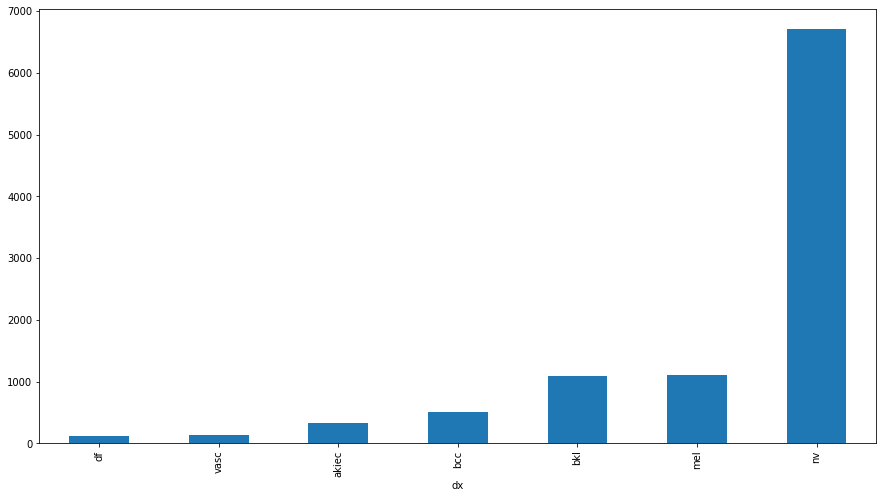

In [9]:
plt.figure(figsize=(15,8))
annotation_df.groupby(LABEL_COLUMN).count()['sex'].sort_values().plot(kind='bar')

In [10]:
annotation_df.groupby(LABEL_COLUMN)['age'].describe()

,count,mean,std,min,25%,50%,75%,max
dx,,,,,,,,
akiec,327.0,66.529052,11.476232,30.0,60.0,70.0,75.0,85.0
bcc,514.0,66.828794,13.656959,20.0,60.0,70.0,75.0,85.0
bkl,1089.0,64.283747,14.120715,0.0,55.0,65.0,75.0,85.0
df,115.0,53.043478,13.551326,25.0,45.0,50.0,65.0,80.0
mel,1111.0,60.679568,15.189847,5.0,50.0,60.0,70.0,85.0
nv,6660.0,46.477477,15.183275,0.0,35.0,45.0,55.0,85.0
vasc,142.0,51.373239,21.644651,0.0,40.0,55.0,70.0,85.0


### View sample images

In [23]:
# sample_image = plt.imread("../lesions.png")
# plt.figure(figsize=(15,8))
# plt.axis('off')
# plt.imshow(sample_image);

## Experiment design

### Monitoring experiments

### Metrics

## Implementation details

## Results

## Conclusions

### Future work

* Use additional data from other datasets
* Include additional information (age) however be sure not to fixate on that...